In [22]:
import json
import random
import math
import copy
import matplotlib.pyplot as plt

import pandas as pd

from IPython.display import display, clear_output

In [84]:
def tuple_sym(u):
    u['u_si']['si_syms'] = tuple(sorted(u['u_si']['si_syms'].items()))
    u['u_si']['si_base_syms'] = u['u_si']['si_syms']
    return u

def flip_unit(u):
    u = copy.deepcopy(u)
    u['u_name'] = 'per %s' % u['u_name']
    u['u_si']['si_fac'] = 1 / u['u_si']['si_fac']
    u['u_si']['si_syms'] = tuple((a, -b) for a, b in u['u_si']['si_syms'])
    u['u_sym'] = '1/(%s)' % u['u_sym']
    return u
    
with open('../data/u2si.2.json', 'r') as f:
    D = json.load(f)
    D = [tuple_sym(d) for d in D if d['u_si']['si_fac'] != 0]
    D += [flip_unit(d) for d in D]

In [80]:
def dict_x(A, B, f):
    A = dict(A)
    B = dict(B)
    D = {}
    for k in set().union(A, B):
        a = A[k] if k in A else 0
        b = B[k] if k in B else 0
        D[k] = f(a, b)
    return D

def unit_merge(a, b):
    r = copy.deepcopy(a)
    r['u_name'] = '%s - %s' % (a['u_name'], b['u_name'])
    r['u_si']['si_fac'] = a['u_si']['si_fac'] * b['u_si']['si_fac']
    r['u_si']['si_syms'] = tuple(dict_x(a['u_si']['si_syms'], b['u_si']['si_syms'], lambda a, b: a + b).items())
    r['u_sym'] = '%s · %s' % (a['u_sym'], b['u_sym'])
    return r

In [4]:
groupD = {}
for di, d in enumerate(D):
    sym = d['u_si']['si_syms']
    if sym not in groupD:
        groupD[sym] = []
    groupD[sym].append(d)

In [5]:
sum([len(a) * len(b) * len(c) for ak, a in groupD.items() for bk, b in groupD.items() for ck, c in groupD.items() if len(set([ak, bk, ck])) == 3])

7943443032

In [6]:
A = [(d, [d['u_si']['si_base_syms']]) for d in D]
for _ in range(1):
    B = []
    for ai, (a, ags) in enumerate(A):
        for g, ds in groupD.items():
            if g not in ags:
                next_ags = ags+[g]
                for d in ds:
                    B.append((unit_merge(a, d), next_ags))
    A = [b[0] for b in B]

In [9]:
Q_LIM = 8
FILT_NUM = 64
VEC_SCORE_MULT = 0.1
def SS(b, u, uu):
    D_ = [d for d in A if d['u_si']['si_syms'] == uu]
    def S(U, q=0):
    #     print(sum(dict_x(bu, U[0][1], lambda a, b: abs(a - b)).values()))
        V = sorted([
            (
    #             (abs(math.log(max(v, 1E-12) / b)) + VEC_SCORE_MULT * sum(dict_x(bu, uu, lambda a, b: abs(a - b)).values())) * (not ended_), # score
                abs(v - b),
                v, # home unit value
#                 vu, # home unit
                ended_, # end condition
                path + [(d['u_sym'], d['u_si']['si_fac'])] # path
            )
            for d in D_
            for u, path in U
            for v in [round(u * d['u_si']['si_fac']) / d['u_si']['si_fac']]
#             for vu in [dict_x(d['u_si']['si_syms'], uu, lambda a, b: a + b)]
            for ended_ in [abs(b - v) < 0.5] # and bu == vu
        ], key=lambda a: a[0])
        print(len(V))

        if q > Q_LIM:
            plt.plot([v[0] for v in V])
            return None
            
        for score, v, ended_, path in V:
            if ended_:
                return path, score, v
            
        return S([(v[1], v[3]) for v in V[:FILT_NUM]], q + 1)
    
    return S([(u, [])])

52234
3342976
3342976
3342976
3342976
3342976
3342976
3342976
3342976
3342976


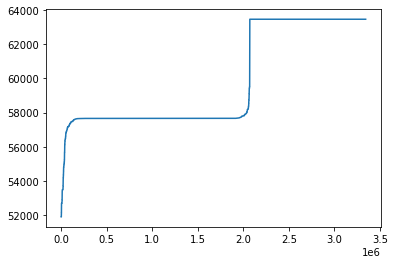

In [10]:
SS(63471, 13, (('m', 1),))

In [12]:
groupA = {}
for a in A:
    k = a['u_si']['si_syms']
    if k not in groupA:
        groupA[k] = []
        
    
    groupA[k].append(a)

In [74]:
SI_0 = { a: 0 for a in 'm,A,cd,s,mol,K,kg'.split(',') }
def standardize_syms(u):
    u_si = copy.copy(SI_0)
    for v, vx in dict(u).items():
        if v in u_si:
            u_si[v] = vx
    
    return u_si

def unit2csv(u):
    u_si = standardize_syms(u['u_si']['si_syms'])
    return '"%s","%s",%.10e,%d,%d,%d,%d,%d,%d,%d\n' % (
        u['u_name'],
        u['u_sym'],
        u['u_si']['si_fac'],
        *u_si.values()
    )

In [104]:
with open('unit_combos.csv', 'w') as f:
    f.write('long_name,name,factor,si_m,si_a,si_cd,si_s,si_mol,si_k,si_kg\n')
    for ai, a in enumerate(D):
        f.write(unit2csv(a))
        
        if ai % 64 == 0:
            clear_output()
            display(ai)
            
        for b in D[ai+1:]:
            if a != b:
                c = unit_merge(a, b)
                f.write(unit2csv(c))

In [78]:
import psycopg2 as pg
import psycopg2.extras as pg_extras
def T(to, fro, unit):
    si_unit = standardize_syms(unit)
    creds = ' user=postgres password=postgres'
    diff = float('inf')
    path = []
    while abs(to - fro) > 0.5:
        with pg.connect('dbname=x2585 ' + creds) as conn:
            cur = conn.cursor() # cursor_factory=pg_extras.RealDictCursor)

            q = '''SELECT * FROM (SELECT *, ABS(LOG(st0.out / %%s)) AS diff FROM (SELECT long_name, name, factor, ROUND(%%s / factor) * factor AS out FROM units WHERE %s) st0 WHERE st0.out > 0) st1 ORDER BY st1.diff ASC LIMIT 1;''' % ' AND '.join(['si_%s=%%s' % k.lower() for k in si_unit.keys()])
            cur.execute(q, (to, fro,) + tuple(si_unit.values()))
            row = cur.fetchone()
            long_name, via, factor, fro, diff = row
            print(row)
#             print(q % tuple([str(a) for a in (to, fro,) + tuple(si_unit.values())]))
            path.append((via, factor, fro))
#             return
    return path

In [86]:
T(31484, 1, { 'm': 1, 's': -1 })

('rad - per foot per minute', 'rad · 1/(ft/min)', 1.968503937, 1.968503937, 4.203953616009846)
('thousand barrels per day - per cubic yard per (mile)', 'koilbbl/d · 1/(cuyd/mi)', 3.8733693416, 3.8733693416, 3.910000993009464)
('cubic foot per second - per pondemaat', 'Mcuft/s · 1/(pond)', 7.7065994369, 7.7065994369, 3.6112271173169916)
('large calorie per day - per microwatt-hour', 'Cal/d · 1/(uWh)', 13.451646091, 13.451646091, 3.3693144710961387)
('mpg<sub>&#8209;imp</sub> - imperial gallon per minute', 'mpgimp · impgal/min', 26.8224, 26.8224, 3.069592268906458)
('centimetre per second - per foot per mile', 'cm/s · 1/(ft/mi)', 52.8, 52.8, 2.7754559811903774)
('gallon per hour - per litre per (kilometer)', 'USgal/h · 1/(L/100km)', 105.15032733, 105.15032733, 2.476279274753286)
('electrical horsepower - per milliwatt-hour', 'hpelectrical · 1/(mWh)', 207.22222222, 207.22222222, 2.1816535770234653)
('cubic foot per (square mile) - curie', 'cuft/sqmi · Ci', 404.52823691, 404.52823691, 1.89

[('rad · 1/(ft/min)', 1.968503937, 1.968503937),
 ('koilbbl/d · 1/(cuyd/mi)', 3.8733693416, 3.8733693416),
 ('Mcuft/s · 1/(pond)', 7.7065994369, 7.7065994369),
 ('Cal/d · 1/(uWh)', 13.451646091, 13.451646091),
 ('mpgimp · impgal/min', 26.8224, 26.8224),
 ('cm/s · 1/(ft/mi)', 52.8, 52.8),
 ('USgal/h · 1/(L/100km)', 105.15032733, 105.15032733),
 ('hpelectrical · 1/(mWh)', 207.22222222, 207.22222222),
 ('cuft/sqmi · Ci', 404.52823691, 404.52823691),
 ('cuft/min · mi/usqt', 802.58194286, 802.58194286),
 ('W · 1/(grf)', 1573.6626017, 1573.6626017),
 ('mi/usqt · koilbbl/d', 3129.28, 3129.28),
 ('W · 1/(PeV)', 6241.5096471, 6241.5096471),
 ('km/h · 1/(sqft/acre)', 12100.0, 12100.0),
 ('days · km/hs', 24000.0, 24000.0),
 ('km3/a · 1/(m3/km)', 31688.087814, 31688.087814),
 ('foot/s · 1/(ft/nmi)', 1852.0, 31484.0)]

In [103]:
import re

request = type('', (), {})() # thx https://stackoverflow.com/questions/19476816/creating-an-empty-object-in-python
request.form = {
    'term_unit': 'mph * gal/s',
    'term_start': '1.394e4',
    'term_end': '15'
}
creds = ' user=postgres password=postgres'
def solve():
  with pg.connect('dbname=x2585 ' + creds) as conn:
    cur = conn.cursor(cursor_factory=pg_extras.RealDictCursor)
    
    unit = copy.copy(SI_0)
    unit_factor = 1.0
    unit_name = '' # TODO
    unit_sym = '' # TODO
    for a in re.split(r'\W', request.form['term_unit']):
      if len(a) > 0:
        cur.execute('SELECT * FROM units WHERE name LIKE %s LIMIT 1', (a,))
        d = cur.fetchone()
        if d != None:
          unit_factor *= d['factor']
          for si in unit.keys():
            unit[si] += d['si_%s' % si.lower()]
        else:
          return { 'err': 'Unit %s was not recognized.' % a }
    
    try:
      fro = float(request.form['term_start']) * unit_factor
      to = float(request.form['term_end']) * unit_factor
    except ValueError:
      return { 'err': 'Start and/or end values "%s" and "%s" are invalid: must be numeric.' % (request.form['term_start'], request.form['term_end']) }
      
    print(to, fro)
    diff = float('inf')
    path = []
    while abs(to - fro) / unit_factor > 0.5:
      q = '''SELECT * FROM (SELECT *, ABS(LOG(st0.vto / %%s)) AS diff FROM (SELECT long_name AS vto_unit_long, name AS vto_unit, factor, ROUND(%%s * factor) / factor AS vto FROM units WHERE %s) st0 WHERE st0.vto > 0) st1 ORDER BY st1.diff ASC LIMIT 1;''' % ' AND '.join(['si_%s=%%s' % k.lower() for k in unit.keys()])
      cur.execute(q, (to, fro,) + tuple(unit.values()))
      row = cur.fetchone()
      fro = row['vto']
      path.append(row)
    return path

solve()

0.0253834572587904 23.58969294583588
RealDictRow([('vto_unit_long', 'US barrel - royal cubit'), ('vto_unit', 'usbbl · royal cubit'), ('factor', 0.062482006907), ('vto', 16.00460755827559), ('diff', 2.7996942562309295)])
RealDictRow([('vto_unit_long', 'board foot - DPI'), ('vto_unit', 'board feet · dpi'), ('factor', 0.092903040028), ('vto', 10.763910413465593), ('diff', 2.627419301292255)])
RealDictRow([('vto_unit_long', 'smoot - kilderkin'), ('vto_unit', 'smoot · kilderkin'), ('factor', 0.13925764732), ('vto', 7.180934183830501), ('diff', 2.4516301730189025)])
RealDictRow([('vto_unit_long', 'rod - firkin'), ('vto_unit', 'rod · firkin'), ('factor', 0.20576876245), ('vto', 4.85982414479939), ('diff', 2.2820697811388744)])
RealDictRow([('vto_unit_long', 'tsubo - square foot'), ('vto_unit', 'tsubo · sqft'), ('factor', 0.3071174876), ('vto', 3.256082901089739), ('diff', 2.108144680416309)])
RealDictRow([('vto_unit_long', 'imperial gallon - dot/cm'), ('vto_unit', 'impgal · dpcm'), ('factor',

[RealDictRow([('vto_unit_long', 'US barrel - royal cubit'),
              ('vto_unit', 'usbbl · royal cubit'),
              ('factor', 0.062482006907),
              ('vto', 16.00460755827559),
              ('diff', 2.7996942562309295)]),
 RealDictRow([('vto_unit_long', 'board foot - DPI'),
              ('vto_unit', 'board feet · dpi'),
              ('factor', 0.092903040028),
              ('vto', 10.763910413465593),
              ('diff', 2.627419301292255)]),
 RealDictRow([('vto_unit_long', 'smoot - kilderkin'),
              ('vto_unit', 'smoot · kilderkin'),
              ('factor', 0.13925764732),
              ('vto', 7.180934183830501),
              ('diff', 2.4516301730189025)]),
 RealDictRow([('vto_unit_long', 'rod - firkin'),
              ('vto_unit', 'rod · firkin'),
              ('factor', 0.20576876245),
              ('vto', 4.85982414479939),
              ('diff', 2.2820697811388744)]),
 RealDictRow([('vto_unit_long', 'tsubo - square foot'),
              ('vto